# Xopt Evaluator Basic Usage 

The `Evaluator` handles the execution of the user-provided `function` with optional `function_kwags`, asyncrhonously and parallel, with exception handling. 

In [1]:
# needed for macos
import platform
if platform.system() == "Darwin": import multiprocessing;multiprocessing.set_start_method("fork")


In [2]:
from xopt import Xopt, Evaluator, Generator, VOCS
from xopt.generators.random import RandomGenerator

from time import sleep
from numpy.random import randint

from typing import Dict

import numpy as np
np.random.seed(666) # for reproducibility

Define a custom function `f(inputs: Dict) -> outputs: Dict`. 

In [3]:
def f(inputs: Dict) -> Dict:

    sleep(randint(1, 5)*.1)  # simulate computation time
    # Make some occasional errors
    if inputs["x"] > 0.8:
        raise ValueError("x > 0.8")

    return {"f1": inputs["x"] ** 2 + inputs["y"] ** 2}

Define variables, objectives, constraints, and other settings (VOCS)

In [4]:
vocs = VOCS(variables={"x": [0, 1], "y": [0, 1]}, objectives={"f1": "MINIMIZE"})
vocs



VOCS(variables={'x': [0.0, 1.0], 'y': [0.0, 1.0]}, constraints={}, objectives={'f1': 'MINIMIZE'}, constants={}, linked_variables={})

This can be used to make some random inputs for evaluating the function. 

In [5]:
in1 = vocs.random_inputs()

f(in1)

{'f1': 0.11401572022703582}

In [6]:
# Add in occasional errors. 
try:
    f({"x": 1, "y": 0})
except Exception as ex:
    print(f"Caught error in f: {ex}")

Caught error in f: x > 0.8


In [7]:
X = Xopt(generator=RandomGenerator(vocs), evaluator=Evaluator(function=f), vocs=vocs)

# Submit to the evaluator some new inputs
X.submit_data(vocs.random_inputs(4))

# Unevaluated inputs are collected in a dataframe
X._input_data

,x,y


In [8]:
# Internal futures dictionary
X._futures

{}

In [9]:
# Collect all finished futures and updata dataframe
X.update_data()
X.data

,x,y,f1,xopt_error,xopt_error_str
1,0.272142,0.951187,0.978818,False,
2,0.048542,0.900071,0.812485,False,
3,0.987297,0.491934,NaN,True,"Traceback (most recent call last):\n File ""/u..."
4,0.586412,0.799752,0.983483,False,


In [10]:
# Futures are now cleared out
X._futures

{}

In [11]:
# This is the internal counter
X._ix_last

4

In [12]:
X.submit_data(vocs.random_inputs(4))
X._input_data

,x,y


In [13]:
X._futures

{}

In [14]:
# Singe generation step
X.step()
X.update_data()
X.data

,x,y,f1,xopt_error,xopt_error_str
1,0.272142,0.951187,0.978818,False,
2,0.048542,0.900071,0.812485,False,
3,0.987297,0.491934,NaN,True,"Traceback (most recent call last):\n File ""/u..."
4,0.586412,0.799752,0.983483,False,
5,0.299155,0.887142,0.876515,False,
6,0.706772,0.889046,1.289930,False,
7,0.225521,0.752332,0.616863,False,
8,0.994891,0.976764,NaN,True,"Traceback (most recent call last):\n File ""/u..."
9,0.802497,0.090820,NaN,True,"Traceback (most recent call last):\n File ""/u..."


# Executors

In [15]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [16]:
MAX_WORKERS = 10

In [17]:
# Dask
# from dask.distributed import Client
# import logging
# client = Client( silence_logs=logging.ERROR)
# executor = client.get_executor()
# client

In [18]:
executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

In [19]:
X2 = Xopt(
    generator=RandomGenerator(vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.options.asynch = True

In [20]:
for _ in range(20):
    X2.step()

<AxesSubplot:xlabel='x', ylabel='y'>

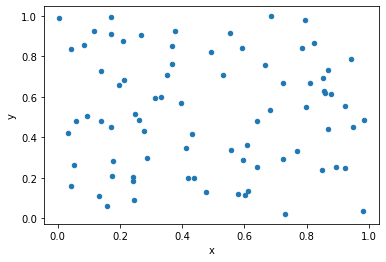

In [21]:
X2.data.plot.scatter("x", "y")

In [22]:
X2.data

,x,y,f1,xopt_error,xopt_error_str
1,0.475619,0.127120,0.242373,False,
2,0.057461,0.478903,0.232650,False,
3,0.925261,0.249796,NaN,True,concurrent.futures.process._RemoteTraceback: \...
4,0.723537,0.670598,0.973208,False,
5,0.532415,0.708698,0.785718,False,
...,...,...,...,...,...
75,0.085719,0.858473,0.744324,False,
76,0.117542,0.927778,0.874588,False,
78,0.352557,0.706213,0.623034,False,
77,0.894553,0.253853,NaN,True,concurrent.futures.process._RemoteTraceback: \...
